In [1]:
import dataframe_image as dfi
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.features import rank1d
from yellowbrick.target import FeatureCorrelation

In [2]:
data = pd.read_csv("../Occupancy_Estimation.csv")
data.columns = data.columns.str.strip().str.lower()
data.insert(2, "datetime", pd.to_datetime(data["date"] + " " + data["time"]))
data["room_occupancy_count"] = data["room_occupancy_count"].astype(int)
data = data.iloc[:, 2:]
data.head()

,datetime,s1_temp,s2_temp,s3_temp,s4_temp,s1_light,s2_light,s3_light,s4_light,s1_sound,s2_sound,s3_sound,s4_sound,s5_co2,s5_co2_slope,s6_pir,s7_pir,room_occupancy_count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017-12-22 10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017-12-22 10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017-12-22 10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017-12-22 10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              10129 non-null  datetime64[ns]
 1   s1_temp               10129 non-null  float64       
 2   s2_temp               10129 non-null  float64       
 3   s3_temp               10129 non-null  float64       
 4   s4_temp               10129 non-null  float64       
 5   s1_light              10129 non-null  int64         
 6   s2_light              10129 non-null  int64         
 7   s3_light              10129 non-null  int64         
 8   s4_light              10129 non-null  int64         
 9   s1_sound              10129 non-null  float64       
 10  s2_sound              10129 non-null  float64       
 11  s3_sound              10129 non-null  float64       
 12  s4_sound              10129 non-null  float64       
 13  s5_co2          

In [4]:
X, y = (
    data.drop(["room_occupancy_count", "datetime"], axis=1),
    data["room_occupancy_count"],
)

/Users/raja_/Documents/GitHub/msds_winter_2022/venv/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


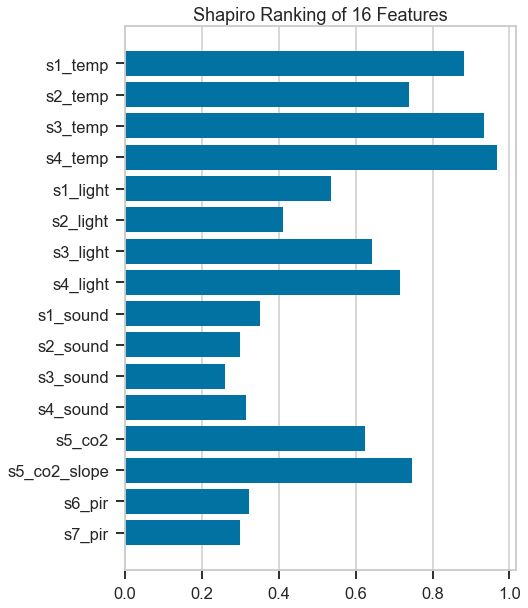

<AxesSubplot:title={'center':'Shapiro Ranking of 16 Features'}>

In [5]:
sns.set_context("talk")
plt.figure(figsize=(7, 10))
rank1d(X, y).show()

In [6]:
# Do a 70-20-10 split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.333333)

In [7]:
for dat, dat_name in [
    (X_train, "X_train"),
    (X_test, "X_test"),
    (X_val, "X_validatation"),
    (y_train, "y_train"),
    (y_test, "y_test"),
    (y_val, "y_validation"),
]:
    print(dat_name)
    print(dat.shape[0])
    print(f"{dat.shape[0]/len(data):.0%} of data")
    print()

X_train
7090
70% of data

X_test
2026
20% of data

X_validatation
1013
10% of data

y_train
7090
70% of data

y_test
2026
20% of data

y_validation
1013
10% of data



Text(0, 0.5, 'Support')

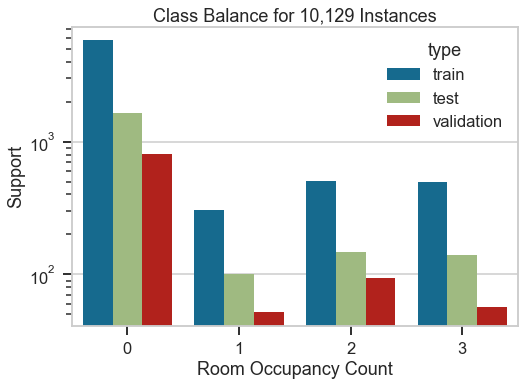

In [8]:
# Create a dataframe of train, test, validation outcomes
outcomes_df = pd.DataFrame()
for dat in [("train", y_train), ("test", y_test), ("validation", y_val)]:
    df = pd.DataFrame(dat[1].values)
    df["type"] = dat[0]
    outcomes_df = pd.concat([outcomes_df, df])
outcomes_df.rename(columns={0: "room_occupancy_count"}, inplace=True)
outcomes_df

sns.countplot(
    x="room_occupancy_count", y=None, hue="type", data=outcomes_df, order=None
)
plt.title("Class Balance for 10,129 Instances")
plt.yscale("log")
plt.xlabel("Room Occupancy Count")
plt.ylabel("Support")

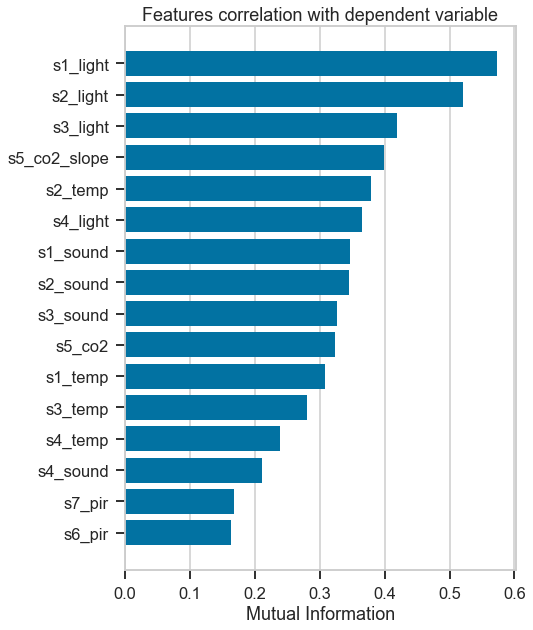

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [9]:
# Instaniate the visualizer
visualizer = FeatureCorrelation(method="mutual_info-classification", sort=True)
plt.figure(figsize=(7, 10))
visualizer.fit(X, y)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

In [10]:
stats = (
    data.drop(columns=["room_occupancy_count", "datetime"])
    .agg(["mean", "std", "median", "min", "max"])
    .round(2)
)
display(stats)
dfi.export(stats, "../stats.png")

,s1_temp,s2_temp,s3_temp,s4_temp,s1_light,s2_light,s3_light,s4_light,s1_sound,s2_sound,s3_sound,s4_sound,s5_co2,s5_co2_slope,s6_pir,s7_pir
mean,25.45,25.55,25.06,25.75,25.45,26.02,34.25,13.22,0.17,0.12,0.16,0.10,460.86,-0.00,0.09,0.08
std,0.35,0.59,0.43,0.36,51.01,67.30,58.40,19.60,0.32,0.27,0.41,0.12,199.96,1.16,0.29,0.27
median,25.38,25.38,24.94,25.75,0.00,0.00,0.00,0.00,0.08,0.05,0.06,0.08,360.00,0.00,0.00,0.00
min,24.94,24.75,24.44,24.94,0.00,0.00,0.00,0.00,0.06,0.04,0.04,0.05,345.00,-6.30,0.00,0.00
max,26.38,29.00,26.19,26.56,165.00,258.00,280.00,74.00,3.88,3.44,3.67,3.40,1270.00,8.98,1.00,1.00


[0316/131853.277606:INFO:headless_shell.cc(659)] Written to file /var/folders/3c/mdbs2nh57lb084xrksjwy50w0000gn/T/tmp765n7cq3/temp.png.


Text(0.5, 0, 'Temperature')

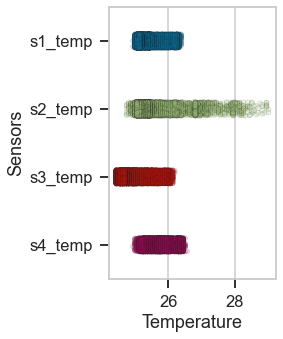

In [11]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "temp" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("Sensors")
plt.xlabel("Temperature")

Text(0.5, 0, 'Light')

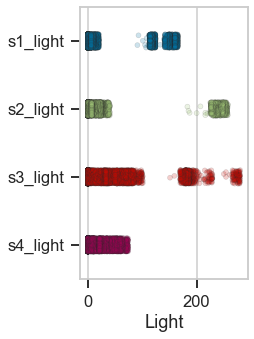

In [12]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "light" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("Light")

Text(0.5, 0, 'sound')

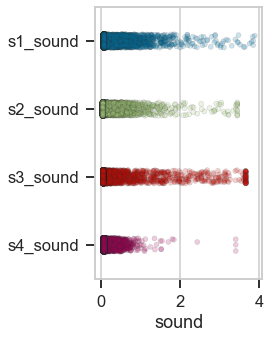

In [13]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[[col for col in data.columns if "sound" in col]].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("sound")

Text(0.5, 0, 'PIR')

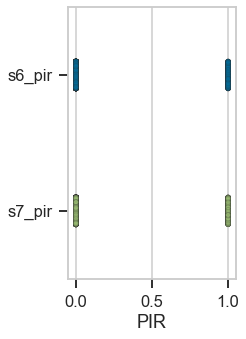

In [14]:
plt.figure(figsize=(3, 5))
sns.stripplot(
    data=data[
        [col for col in data.columns if "pir" in col and "slope" not in col]
    ].melt(),
    alpha=0.2,
    linewidth=0.5,
    y="variable",
    x="value",
)

plt.ylabel("")
plt.xlabel("PIR")

In [15]:
from sklearn.metrics import confusion_matrix


def transform_predictions(pred_array):
    """Transforms occupancy predictions into discrete values which match expected possible outcomes.
    Rounds predicted value to nearest integer unless predicted value is greater than 3. In which case, assigns 3.
    """
    new_preds = []
    for x in pred_array:
        if x < 0.5:
            new_preds.append(0)
        elif x < 1.5:
            new_preds.append(1)
        elif x < 2.5:
            new_preds.append(2)
        else:
            new_preds.append(3)
    return new_preds


models = [
    Ridge(),
    LinearRegression(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
]

data = [
    ("Train", X_train, y_train),
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test),
]
results = []

for model in models:
    model_name = model.__class__.__name__

    model = Pipeline(
        [
            ("standardization", StandardScaler()),
            (model_name, model),
        ]
    )

    model.fit(X_train, y_train)

    print(model_name)

    for dat_name, x_dat, y_dat in data:

        # print(dat_name, "Data Results:")
        # print(f"   - RMSE: {mean_squared_error(y_dat, transform_predictions(model.predict(x_dat)), squared=False):.3f}")
        # print(f"   - R^2: {r2_score(y_dat, transform_predictions(model.predict(x_dat))):.3f}")
        # print()
        results.append(
            [
                (
                    model_name,
                    "without_pca",
                    "RMSE",
                    dat_name,
                    mean_squared_error(
                        y_dat,
                        transform_predictions(model.predict(x_dat)),
                        squared=False,
                    ),
                )
            ]
        )
        results.append(
            [
                (
                    model_name,
                    "without_pca",
                    "R^2",
                    dat_name,
                    r2_score(y_dat, transform_predictions(model.predict(x_dat))),
                )
            ]
        )

    print("-" * 50)


for model in models:
    model_name = model.__class__.__name__
    model_PCA = Pipeline(
        [
            ("standardization", StandardScaler()),
            ("pca", PCA(n_components=2)),
            (model.__class__.__name__, model),
        ]
    )
    model_PCA.fit(X_train, y_train)
    print(model.__class__.__name__, "with PCA (n components = 2)")
    for dat_name, x_dat, y_dat in data:
        print(dat_name, "Data Results:")
        print(
            f"   - RMSE: {mean_squared_error(y_dat, transform_predictions(model_PCA.predict(x_dat)), squared=False):.3f}"
        )
        print(
            f"   - R^2: {r2_score(y_dat, transform_predictions(model_PCA.predict(x_dat))):.3f}"
        )
        results.append(
            [
                (
                    model_name,
                    "with_pca",
                    "RMSE",
                    dat_name,
                    mean_squared_error(
                        y_dat,
                        transform_predictions(model_PCA.predict(x_dat)),
                        squared=False,
                    ),
                )
            ]
        )
        results.append(
            [
                (
                    model_name,
                    "with_pca",
                    "R^2",
                    dat_name,
                    r2_score(y_dat, transform_predictions(model_PCA.predict(x_dat))),
                )
            ]
        )
        print()
    print("-" * 50)

Ridge
--------------------------------------------------
LinearRegression
--------------------------------------------------
RandomForestRegressor
--------------------------------------------------
DecisionTreeRegressor
--------------------------------------------------
Ridge with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.405
   - R^2: 0.796

Validation Data Results:
   - RMSE: 0.382
   - R^2: 0.809

Test Data Results:
   - RMSE: 0.394
   - R^2: 0.806

--------------------------------------------------
LinearRegression with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.405
   - R^2: 0.796

Validation Data Results:
   - RMSE: 0.382
   - R^2: 0.809

Test Data Results:
   - RMSE: 0.394
   - R^2: 0.806

--------------------------------------------------
RandomForestRegressor with PCA (n components = 2)
Train Data Results:
   - RMSE: 0.081
   - R^2: 0.992

Validation Data Results:
   - RMSE: 0.276
   - R^2: 0.901

Test Data Results:
   - RMSE: 0.255
   - R^2: 0.919



In [16]:
results_df = pd.DataFrame(results)
results_df = pd.DataFrame(
    results_df[0].to_list(), columns=["model", "pca", "metric", "dataset", "value"]
)
results_df.head()

,model,pca,metric,dataset,value
0,Ridge,without_pca,RMSE,Train,0.279280
1,Ridge,without_pca,R^2,Train,0.902858
2,Ridge,without_pca,RMSE,Validation,0.301362
3,Ridge,without_pca,R^2,Validation,0.881175
4,Ridge,without_pca,RMSE,Test,0.273906


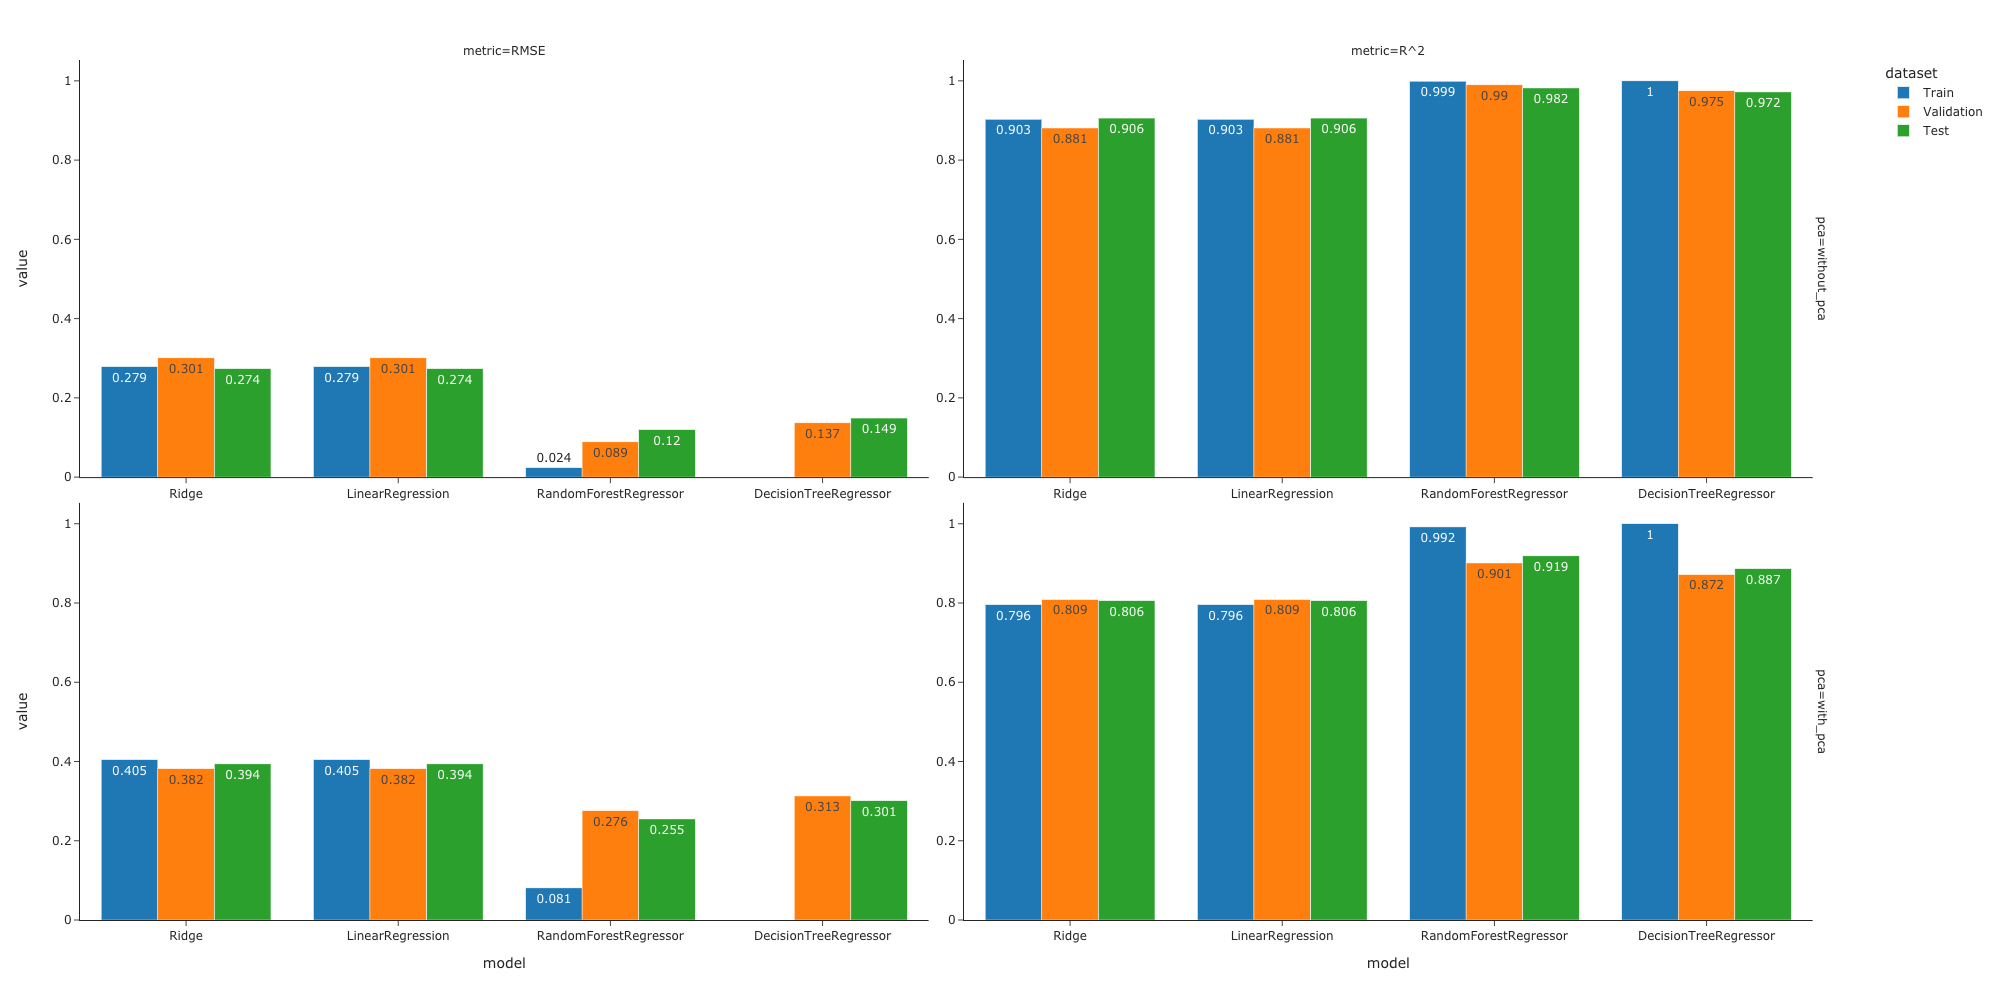

In [17]:
results_df["value"] = results_df["value"].round(3)

(
    px.bar(
        data_frame=results_df,
        x="model",
        y="value",
        color="dataset",
        pattern_shape=None,
        facet_row="pca",
        facet_col="metric",
        facet_col_wrap=0,
        facet_row_spacing=None,
        facet_col_spacing=None,
        hover_name=None,
        hover_data=None,
        custom_data=None,
        text="value",
        base=None,
        error_x=None,
        error_x_minus=None,
        error_y=None,
        error_y_minus=None,
        animation_frame=None,
        animation_group=None,
        category_orders=None,
        labels="value",
        color_discrete_sequence=None,
        color_discrete_map=None,
        color_continuous_scale=None,
        pattern_shape_sequence=None,
        pattern_shape_map=None,
        range_color=None,
        color_continuous_midpoint=None,
        opacity=None,
        orientation=None,
        barmode="group",
        log_x=False,
        log_y=False,
        range_x=None,
        range_y=None,
        text_auto=False,
        title=None,
        template="simple_white",
        width=2000,
        height=1000,
    )
    .update_xaxes(showticklabels=True)
    .update_yaxes(showticklabels=True)
    .show(renderer="png")
)

In [18]:
results_df

,model,pca,metric,dataset,value
0,Ridge,without_pca,RMSE,Train,0.279
1,Ridge,without_pca,R^2,Train,0.903
2,Ridge,without_pca,RMSE,Validation,0.301
3,Ridge,without_pca,R^2,Validation,0.881
4,Ridge,without_pca,RMSE,Test,0.274
5,Ridge,without_pca,R^2,Test,0.906
6,LinearRegression,without_pca,RMSE,Train,0.279
7,LinearRegression,without_pca,R^2,Train,0.903
8,LinearRegression,without_pca,RMSE,Validation,0.301
9,LinearRegression,without_pca,R^2,Validation,0.881


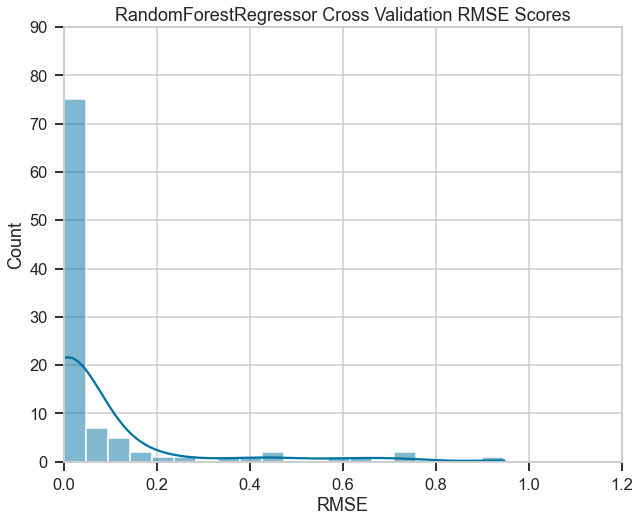

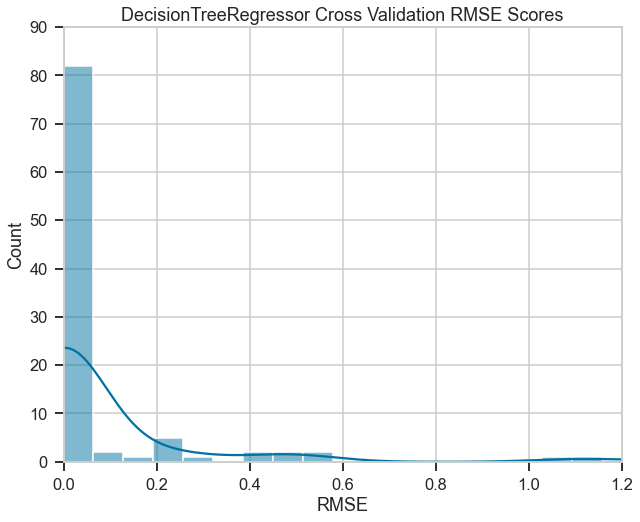

In [19]:
models = [
    RandomForestRegressor(max_depth=10),
    DecisionTreeRegressor(max_depth=10),
]

for model in models:
    scores = cross_validate(
        model, X, y, cv=100, scoring=("neg_mean_squared_error"), n_jobs=-1
    )["test_score"]
    scores *= -1
    scores **= 1 / 2

    plt.figure(figsize=(10, 8))
    sns.histplot(scores, bins=20, kde=True)
    plt.title(f"{model.__class__.__name__} Cross Validation RMSE Scores")
    plt.xlabel("RMSE")
    plt.xlim(0, 1.2)
    plt.ylim(0, 90)
    plt.show()

In [20]:
# Set up a model with a pipeline containing a gridsearch for PCA and gridsearch for random forest classifier

pca_grid = GridSearchCV(
    estimator=PCA(), param_grid={"n_components": [2, len(X_train.columns)]}
)

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={"n_estimators": range(20, 100, 10)},
    cv=10,
    n_jobs=-1,
)

model = Pipeline([("PCA", pca_grid), ("RF", rf_grid)])

model.fit(X_train, y_train)
print(model.__class__.__name__)
for dat_name, x_dat, y_dat in data:
    print(dat_name, "Data Results:")
    print(
        f"   - MSE: {mean_squared_error(y_dat, transform_predictions(model.predict(x_dat)), squared=False):.3f}"
    )
    print()
print("-" * 50)

Pipeline
Train Data Results:
   - MSE: 0.031

Validation Data Results:
   - MSE: 0.157

Test Data Results:
   - MSE: 0.097

--------------------------------------------------


In [21]:
model["RF"].best_params_

{'n_estimators': 60}

<IPython.core.display.Javascript object>

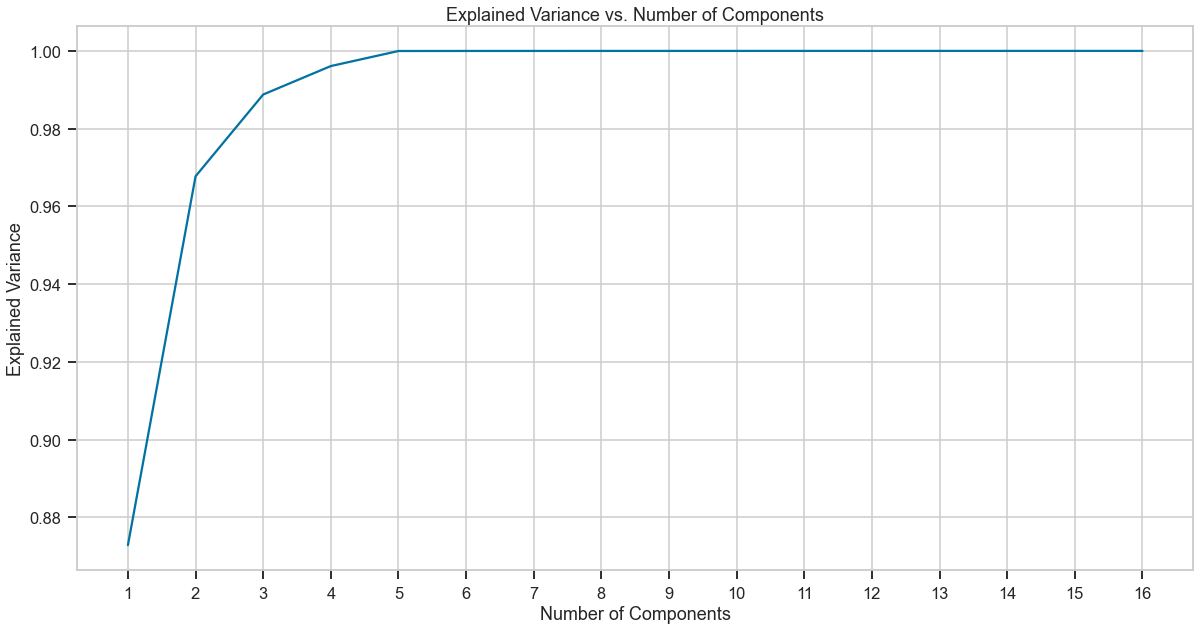

In [22]:
pca = PCA()
pca.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(16), labels=range(1, 17))
plt.title("Explained Variance vs. Number of Components")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.show()

In [23]:
np.cumsum(pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>

array([0.87286433, 0.96774499, 0.98878352, 0.99610386, 0.99997388,
       0.99998897, 0.99999238, 0.99999508, 0.99999645, 0.99999754,
       0.99999842, 0.99999904, 0.99999957, 0.9999998 , 0.99999994,
       1.        ])

In [24]:
pca.explained_variance_ratio_

array([8.72864325e-01, 9.48806621e-02, 2.10385285e-02, 7.32034767e-03,
       3.87002053e-03, 1.50811583e-05, 3.41425403e-06, 2.70413727e-06,
       1.36545646e-06, 1.08712719e-06, 8.83513644e-07, 6.17328765e-07,
       5.34087556e-07, 2.27701802e-07, 1.36680165e-07, 6.44140964e-08])

In [36]:
test_scores_df = results_df[results_df['dataset']=='Test'].set_index(['pca','model','metric'])['value'].to_frame().unstack(level=-1)

In [77]:
pca_compare = results_df[results_df['dataset']=='Test'].set_index(['pca','model','metric'])['value'].to_frame().unstack(level=[0]).reset_index()
pca_compare['percent_difference'] = (pca_compare[('value','with_pca')] - pca_compare[('value','without_pca')]) * (100/abs(pca_compare[('value','with_pca')]))
pca_compare.columns = [c[0] if c[1] == '' else c[1] for c in pca_compare.columns.to_flat_index()]
pca_compare.set_index(['model','metric'], inplace=True)

pca_compare.unstack(level=1)

with_pca        without_pca        percent_difference  \
metric                    RMSE    R^2        RMSE    R^2               RMSE   
model                                                                         
DecisionTreeRegressor    0.301  0.887       0.149  0.972          50.498339   
LinearRegression         0.394  0.806       0.274  0.906          30.456853   
RandomForestRegressor    0.255  0.919       0.120  0.982          52.941176   
Ridge                    0.394  0.806       0.274  0.906          30.456853   

                                  
metric                       R^2  
model                             
DecisionTreeRegressor  -9.582864  
LinearRegression      -12.406948  
RandomForestRegressor  -6.855277  
Ridge                 -12.406948

['model', 'metric', 'with_pca', 'without_pca', 'percent_difference']

In [47]:
test_scores_df[('value','R^2')].values

array([0.887, 0.806, 0.919, 0.806, 0.972, 0.906, 0.982, 0.906])

In [78]:
dfi.export(pca_compare.unstack(level=1), 'test_scores_df.png')

[0316/141016.997332:INFO:headless_shell.cc(659)] Written to file /var/folders/3c/mdbs2nh57lb084xrksjwy50w0000gn/T/tmp_k93uxp2/temp.png.
